## Import modules

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import h5py
from torch.func import vmap
from torch.nn import MSELoss
import torch.nn.functional as F
import torch.cuda.amp as amp
# import pynvml
from torch.utils.data import DataLoader
import sys
import math
import os
from transformer import Transformer
import pickle as pkl
from sklearn.preprocessing import StandardScaler
from functools import wraps
import gc
from utils import *
from utils_maze import *
from model import *
from distributions import *


inter = 6

length = 300
criterion = MSELoss(reduction="sum")

dim=length//inter

device = "cuda" if torch.cuda.is_available() else "cpu" 
print(device)

setup()

cuda


### Setup data

It amounts to load and scale data.

In [ ]:
scaler, Path_Loader, observations, Actions=setup_data()

### Sample and display

Sample from base and target distribution. And check their shapes.

In [ ]:
x=target(n=1000, l=length, inter=inter, array=observations, device=device)

base = BaseDistribution(device = device)
print(x.shape)
base.sample(n=10, l=length//inter, actions=False).shape

In [ ]:
x0s = base.sample(n=1000, l=length//inter)
x1 = target(n=1000, l=length, inter=inter, array=observations)
print("Shape of samples from base distribution is", x0s.shape)
print("Shape of samples from target distributions is", x1.shape)
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax0.scatter(x0s[...,0].cpu(), x0s[..., 1].cpu(), color="black")
ax0.set_title(r"Samples under $\rho_0$", fontsize = 16)
ax1.scatter(x1[:,0,...,0].cpu(), x1[:,0,...,1].cpu(), color="black")
ax1.set_title(r"Samples under $\rho_1$", fontsize = 16)
plt.show()

## Interpolation between base and target distribution

 $\alpha$ should be the same for all dimensions of input space.

### Linear interpolation

$\alpha$ follows a linear scheme: $\alpha_t=1-t$ for $t \in [0, 1]$.

In [ ]:
bs=10000 #batch size
list_alpha = torch.stack([torch.rand(length, device = device) for _ in range(bs)], axis = 0)
interpolant = Interpolant()

In [ ]:
def manual_linear_interpolation(n:int=10, ncol:int=10, color:str='#62508f'):

    ts=torch.linspace(1., 0, ncol, device = device)
    Alpha=torch.cat((ts[:,None],)*(length // inter), axis = 1)

    fig, axes = plt.subplots(1, ncol, figsize=(ncol*4,4))

    x0s=base.sample(n=n, l=length//inter).to(device)
    x1=target(n, l=length, inter=inter, array=observations, device=device)
    for i in range(ncol):
        alpha = Alpha[None, i].repeat(n, 1) #Repeat for each path
        xts = interpolant.xt(x0s, x1, alpha)

        axes[i].scatter(xts.cpu()[...,0], xts.cpu()[..., 1], alpha = 0.8, c = color) # plot samples x_t \sim \rho_t

        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(r'$\rho(\alpha = %.1f)$' % alpha[0, 0].item(), fontsize = 20, weight='bold')

        if i !=0:
            axes[i].set_yticks([])
    plt.show()
manual_linear_interpolation()

### Cosine-planning

This time, take $\alpha_t=\cos(\frac{t+\epsilon}{(1+\epsilon)\pi/2})$, with $t$ uniformly sampled on $[0,1]$. With this scheme, the interpolation is more uniformly spread out between $x_0$ and $x_1$.

In [ ]:
def manual_cosine_interpolation(n:int=10, ncol:int=10, color:str='#62508f'):

    ts=torch.linspace(0, 1, ncol, device = device)
    Alpha=torch.cat((ts[:,None],)*(length // inter), axis = 1)

    fig, axes = plt.subplots(1, ncol, figsize=(ncol*4,4))
    eps=0

    x0s=base.sample(n=n, l=length//inter).to(device)
    x1=target(n=n, l=length, inter=inter, array=observations, device = device)

    for i in range(ncol):
        alpha  = torch.cos((Alpha[None, i].repeat(n, 1) + eps)/(1 + eps)*np.pi/2)**3
        xts = interpolant.xt(x0s, x1, alpha)

        axes[i].scatter(xts.cpu()[...,0], xts.cpu()[..., 1], alpha = 0.8, c = color) # plot samples x_t \sim \rho_t

        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(r'$\rho(\alpha = %.1f)$' % alpha[0, 0].item(), fontsize = 20, weight='bold')

        if i !=0:
            axes[i].set_yticks([])
    plt.show()
manual_cosine_interpolation()

## Instantiate the U-Net neural network

Make sure the pipeline is well defined.

X should have only one channel here.

In [ ]:
b =  VelocityFieldTS(init_features=dim, device="cuda").to(device)

bs = 10 ## simple test batch size

X = target(n=bs, array=observations, l=length, inter=inter, device=device)
Alpha = torch.rand(bs, dim).to(device)

print("Shape of data is", X.shape)
print("Shape of interpolant is", Alpha.shape)

out = b.forward(X, Alpha) ## should output something of shape [bs, length]
print("U-Net output's shape is", out.shape)

### Test it works fine

Declare loss function, and ensure it works properly.

In [ ]:
def loss_fn(b: VelocityFieldTS, interpolant: Interpolant, x0: Tensor, x1: Tensor, alpha: Tensor):
    """
    Interpolant loss function for a single datapoint of (x0, x1, alpha).
    """
    It   = interpolant.xt(x0, x1, alpha)
    dtIt = interpolant.dtxt(x0, x1)
    bt          = b.forward(It, alpha)
    loss        = criterion(bt.squeeze(), dtIt.squeeze())/len(x0)
    return loss

test_Unet(n=10, length=length, inter=inter, array=observations)

## Training the Neural Network

In [ ]:
Index = torch.linspace(0, 1, 1000)
def train_step(b: VelocityFieldTS, Dataloader: DataLoader, interpolant: Interpolant, opt: torch.optim, sched: torch.optim.lr_scheduler, N: int, Scaler, eval_ = False):
    """
    N (int): batch size.
    eval_ (bool): Eval the dataset.
    """
    global inter
    b.train()
    
    opt.zero_grad()
    x1s = target(n=N, l=length, inter=inter, array=observations, device=device) #Sample from observations
    x0s = base.sample(n=N, l=length // inter) #Sample base distribution
    
    # alpha = torch.rand(N, 1).to(device).repeat(1, length) #For training on diagonal hypercube
    alpha = torch.rand(N, length//inter).to(device)
    
    with amp.autocast():
        loss_train = loss_fn(b, interpolant, x0s, x1s, alpha).mean()
    # perform backprop
    Scaler.scale(loss_train).backward() #Scale the loss
    torch.nn.utils.clip_grad_norm_(b.parameters(), max_norm = 10) #Clip the norm of the gradients
    Scaler.step(opt) #Update the parameters' gradient
    Scaler.update()
    sched.step()
    
    if eval_:
        b.eval()
        x0s_eval = base.sample(N//2, length//inter)
        x1s_eval = target_with_alpha(N//2, length//inter, array=(observations, actions), device=device)
        alpha_eval = torch.rand(N//2, 1).to(device).repeat(1, length)
        # alpha_eval = torch.rand(N//2, length, device = device)
        #Evaluate loss on validation dataset
        loss_eval = loss_fn(b, interpolant, x0s_eval, x1s_eval, alpha_eval).mean()
    else:
        loss_eval = torch.tensor(torch.nan)
    res = {
            'loss': loss_train.detach(),
            'loss_eval': loss_eval.detach()
        }
    return res


def train(b:VelocityFieldTS, warm_up:str=False, path:str="weight_CONV_MAZE_L100.pth"):
    interpolant = Interpolant()
    if warm_up:
        b.load_state_dict(torch.load(path))
    print("This model has", sum(p.numel() for p in b.parameters()), "parameters.")
    lr = 1e-3
    weight_decay = 0.1
    n_opt = 8000
    Scaler = amp.GradScaler()
    opt = torch.optim.AdamW(b.parameters(), lr = lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=.999)
    
    losses = []
    losses_eval = []
    from tqdm import tqdm
    pbar = tqdm(range(n_opt))
    for i in pbar:
        
        res = train_step(b, Path_Loader, interpolant, opt, sched, bs, Scaler, eval_ = eval_)

        loss = res['loss'].to('cpu').detach().numpy().mean()
        loss_v = res['loss_eval'].to('cpu').detach().numpy().mean()
        
        losses.append(loss)
        losses_eval.append(loss_v)
        pbar.set_description(f'Loss: {loss:.4f}, Loss eval: {loss_v: .4f}')

        if i%100==0:
            torch.save(b.state_dict(), path)

    plt.plot(losses, label="Training Loss")
    # if eval_:
    #     plt.plot(losses_eval, label="Evaluation Loss")
    # plt.legend()

#### Running the Training

We are now ready to train our model. Let's build a loop that runs for `n_opt` steps and store the loss over time.

Create a Path loader for training.

In [ ]:
chunk = len(observations)//(length//inter)
obs = np.split(observations, chunk, axis=0)
bs = 3000 #batch size
Path_Loader = DataLoader(dataset=obs, batch_size=bs, shuffle=True)

In [ ]:
%%time
Load = True
warm_up = False
eval_ = False
# b = VelocityFieldTS(init_features=length//inter, device="cuda")

loss_min = 1e5

if not Load:
    train(b=b, warm_up=warm_up, path="weight_CONV_MAZE_L50.pth")
    
if Load:
    b.load_state_dict(torch.load("weight_CONV_MAZE_L50.pth"))
    print("This model has", sum(p.numel() for p in b.parameters()), "parameters.")
    b.eval()

In [ ]:
interpolant = Interpolant()

class SDE:
    def __init__(self, b, interpolant, eps, n_step, Alpha = None, mask = None, device: str = device):
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*(length//inter), axis = 1)
        else:
            self.alpha = Alpha

        if mask is None:
            self.mask = torch.ones(length//inter*2, device = device).reshape(length//inter, 2)
        else:
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

        self.dt          = 1/n_step
        self.eps         = eps
        self.sqrtepsdt   = torch.sqrt(torch.tensor(2.0)*self.eps*self.dt)

        self.device = device

    def step(self, x, alpha):
        alpha_t = self.interpolant.alpha(alpha).reshape(-1, 1, length//inter, 1)
        gen = self.b(x, alpha)
        alpha_t = alpha_t.repeat(1, 1, 1, 2).to(device)
        return x + (-gen*self.dt + torch.sqrt(alpha_t)*self.sqrtepsdt*torch.randn(x.size(), device = self.device) - self.eps*(x + (1 - alpha_t)*gen)*self.dt)*self.mask

    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        bs = x_init.shape[0]
        xs = torch.zeros((self.n_step, *x_init.shape), device = device)
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(len(x), 1).to(device) #Repeat for each batch size
            x = self.step(x, alpha)
            xs[i] = x
        return xs

# eps = torch.tensor(0.7)
# sde = SDE(b, interpolant, eps = eps, n_step = 80, device = device)
# n_bs = 5
# x0s= base.sample(n_bs, length//inter)
# x0s = x0s.to(device)
# x_init = x0s.clone().detach().to(device)  # Assume this is your forward-solved endpoint
# x_final = sde.solve(x_init)
# print(x_final.device)
# x1s = x_final[-1].cpu().detach().numpy()  # This should give you the noise

### Full path generation without constraint

The whole path is generated at once. The only expectation is to not have a single point within a wall case.

torch.Size([1, 1, 50, 2])
Done.
0


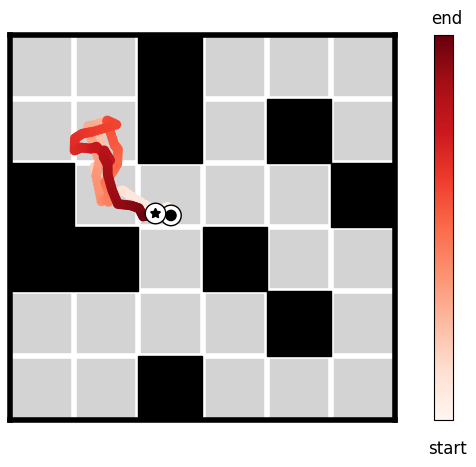

In [16]:
def full_path_generation(b: VelocityFieldTS, n_step: int=80, eps:float=.7, device=device, N:int=length//inter, scaler=scaler):
    sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7)
    batch_size=1
    x0s = base.sample(n=batch_size, l=length//inter, actions=False)

    x0s = x0s.to(device)
    x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
    print(x_init.shape)
    # x_init = ode.solve(x_init)
    x_final = sde.solve(x_init).squeeze(2)
    x1s = x_final[-1].cpu().detach().numpy()  # This should give you the noise

    x1s = interpolate(x1s)
    plot_maze(obs=x1s, scaler=scaler)
    print("The number of points within a wall case is", count_in_wall(x1s))
full_path_generation(b)

### Generation on conditioning firsts and lasts points

The path is here generated connecting two predetermined endpoints. The pathway's length should be adapted accordingly. You still need to specify the index of the path's end point.

In [22]:
#Take a random index to impose a number of point in the path. In practice, it must be CHOSEN WISELY.
idx = np.random.randint(low=7, high=50)
idx = -1
#Load in the set of start and end point
with open("Points.pth", mode="rb") as f:
    points = pkl.load(f)

def shortest_path(start_point: np.ndarray, end_point: np.ndarray, idx: int=-1):
    
    Alpha = torch.stack((torch.linspace(1.0,0.0, 80 + 1, device = device),)*((length//inter)), axis = 1)
    Alpha[:,idx] = 0
    Alpha[:,0] = 0
    
    mask = torch.ones((length//inter), device = device)
    mask[idx] = 0
    mask[0] = 0
    mask = torch.concatenate((mask[:,np.newaxis], mask[:,np.newaxis]), axis = 1)
    
    sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7, Alpha=Alpha, mask=mask)
    n_bs = 1
    
    x0s = base.sample(n_bs, length//inter)
    x0s = x0s.to(device)
    x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
    x_init[:, 0, idx], x_init[:, 0, 0] = torch.tensor(goal_point, device=device), torch.tensor(start_point, device=device)
    
    x_final = sde.solve(x_init).squeeze(2) #Remove the useless channel axis
    x1s = x_final[-1].cpu().detach().numpy() #Keep the last time step
    x1s = interpolate(x1s)
    plot_maze(obs=x1s, scaler=scaler, save=False, title="Number of in-wall points {}".format(count_in_wall(x1s)))


100%|███████████████████████████████████████████████████████████████████| 10000/10000 [8:15:54<00:00,  2.98s/it]

0


### Generate the path between start point $0$ and end point at idx

In [24]:
#Take a random index to impose a number of point in the path

path = os.path.join(os.getcwd(), "maze/conditioned_on_endpoints/goal_point_fixed/{}")

idx = np.random.randint(low=7, high=50)
idx = 49
#Load in the set of start and end point
with open("Points.pth", mode="rb") as f:
    points = pkl.load(f)

#Choose a pair or start and end point.
idxx=4
start_point = torch.tensor(points[idxx, 0], device=device)
end_point = torch.tensor(points[idxx, 1], device=device)

start_point = scaler.transform(np.array(([[0.47704682 +.4, 0.6697078 +.4]])))
end_point = scaler.transform(np.array([[6.217887 + .2, 6.217159 + .2]]))

start_point = torch.tensor(start_point, device=device)
end_point = torch.tensor(end_point, device=device)

Alpha = torch.stack((torch.linspace(1.0,0.0, 80 + 1, device = device),)*((length//inter)), axis = 1)
Alpha[:,idx] = 0
Alpha[:,0] = 0

mask = torch.ones((length//inter), device = device)
mask[idx] = 0
mask[0] = 0
mask = torch.concatenate((mask[:,np.newaxis], mask[:,np.newaxis]), axis = 1)

sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7, Alpha=Alpha, mask=mask)
n_bs = 1

x0s = base.sample(n_bs, length//inter)
x0s = x0s.to(device)
x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
x_init[:, 0, idx], x_init[:, 0, 0] = end_point, start_point


# x_init = ode.solve(x_init)
x_final = sde.solve(x_init).squeeze(2) #Remove the channel axis
x1s = x_final[-1].cpu().detach().numpy() #Keep the last time step
x1s = x1s[:, :idx]
# plot_maze(x_init.cpu().numpy().squeeze(1))
plot_maze(obs=x1s, index=0, scaler=scaler, save=True, path=path.format("cross_whole_maze"))
# plot_maze(x_t.cpu().numpy().squeeze(1))

TypeError: plot_maze() got an unexpected keyword argument 'index'

## Generate a path sequentially
Do not work, memory leaking

In [25]:
class Interpolant:
    def _single_xt(self, x0, x1, alpha):
        return alpha*x0 + (1 - alpha)*x1
        
    def alpha(self, alpha):
        return alpha
        
    def dotalpha(self, alpha):
        return -1.0 + 0*alpha
        
    def beta(self, alpha):
        return 1 - alpha
        
    def dotbeta(self, alpha):
        return 1.0 + 0*alpha
        
    def _single_dtxt(self, x0, x1):
        return x0 - x1
    
    def xt(self, x0, x1, alpha):
        if len(alpha.shape) == 2:
            alpha = alpha[...,np.newaxis].repeat(1, 2)
        elif len(alpha.shape) == 3:
            alpha = alpha[...,np.newaxis].repeat(1, 1, 2)
        return vmap(self._single_xt, in_dims=(0, 0, 0))(x0,x1,alpha)
    
    def dtxt(self, x0, x1):
        return vmap(self._single_dtxt, in_dims=(0, 0))(x0,x1)
    
interpolant = Interpolant()

class SDE:
    def __init__(self, b, interpolant, eps, n_step, Alpha = None, mask = None, device: str = device):
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*(length//inter), axis = 1)
        else:
            self.alpha = Alpha

        if mask is None:
            self.mask = torch.ones(length//inter*2, device = device).reshape(length//inter, 2)
        else:
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

        self.dt          = 1/n_step
        self.eps         = eps
        self.sqrtepsdt   = torch.sqrt(torch.tensor(2.0)*self.eps*self.dt)

        self.device = device

    def step(self, x: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
        # mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
        # a = mem.free

        #Memory leak
        gen = self.b(x, alpha)
        # mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
        # print(mem.free - a)

        #No memory leak
        alpha_t = self.interpolant.alpha(alpha).reshape(-1, 1, length//inter, 1)
        alpha_t = alpha_t.repeat(1, 1, 1, 2).to(device) #Same alpha for both coordinate
        
        return x + (-gen*self.dt + torch.sqrt(alpha_t)*self.sqrtepsdt*torch.randn(x.size(), device = self.device) - self.eps*(x + (1 - alpha_t)*gen)*self.dt)*self.mask

    @wrapper_memory
    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        bs = x_init.shape[0]
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(x.shape[1], 1).to(device) #Repeat for each batch size

            #Memory leak
            x = self.step(x, alpha)
        return x


## Find a starting Point

The objective of this section of code is to find a starting point such that the path length is of at least $40$ points.
I do use it only to make figures.

In [ ]:
Starting_Point = []

In [ ]:
while len(Starting_Point) < 100:
    
    for idx in Time:
    
        # start_point = scaler.transform(np.array(([[2, 2]])))
        # end_point = scaler.transform(np.array([[6, 6.]]))
    
        start_point, _, end_point = points[1]
        start_point = torch.tensor(start_point, device=device)
        end_point = torch.tensor(end_point, device=device)
        
        #Fix alpha and mask at the start and end point.
        Alpha = torch.stack((torch.linspace(1.0,0.0, 80 + 1, device = device),)*((length//inter)), axis = 1)
        Alpha[:,idx] = 0
        Alpha[:,0] = 0
        
        mask = torch.ones((length//inter), device = device)
        mask[idx] = 0
        mask[0] = 0
        mask = torch.concatenate((mask[:,np.newaxis], mask[:,np.newaxis]), axis = 1)
        
        sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7, Alpha=Alpha, mask=mask)
        n_bs = 1
        
        x0s = base.sample(n_bs, length//inter)
        x0s = x0s.to(device)
        x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
        x_init[:, 0, idx], x_init[:r, 0, 0] = end_point, start_point
        
        x_final = sde.solve(x_init).squeeze(2) #Remove the channel axis (it is of size 1)
        x1s = x_final[-1].cpu().detach().numpy() #Keep the last time step, at the end of diffusion
        x1s = x1s[:, :idx+1]
        x1s = interpolate(x1s, length=idx*7, inter=7)
        counter = count_in_wall(x1s, scaler=scaler)
        if not counter and idx >= 40:
            # plot_maze(obs=x1s, scaler=scaler, save=False)
            Starting_Point.append(start_point)
            # np.save(os.path.join(os.getcwd(), "paths", f"paths_9{1}.pth"), x1s)
            break

---

# Add a constraint at the path mid-length.

In [48]:
def find_length(start_point: np.ndarray, end_point: np.ndarray, device, scaler=None):
    """
    Find out the best path length. Only one at a time please.
    """
    global length, inter
    Time = [5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
    
    if scaler is not None:
        # start_point = scaler.transform(np.array(([[2, 2]])))
        # end_point = scaler.transform(np.array([[6, 6.]]))
        start_point=scaler.transform(start_point)
        end_point=scaler.transform(end_point)
    
    #Convert to tensor
    start_point, end_point = torch.tensor(start_point, device=device), torch.tensor(end_point, device=device)
    
    for idx in Time:
                    
        Alpha = torch.stack((torch.linspace(1.0,0.0, 80 + 1, device = device),)*((length//inter)), axis = 1)
        Alpha[:,idx] = 0
        Alpha[:,0] = 0
        
        mask = torch.ones((length//inter), device = device)
        mask[idx] = 0
        mask[0] = 0
        mask = torch.concatenate((mask[:,np.newaxis], mask[:,np.newaxis]), axis = 1)
        
        sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7, Alpha=Alpha, mask=mask)
        n_bs = 1 #Only one sample, no need to do more.
        
        x0s = base.sample(n=n_bs, l=length//inter)
        x0s = x0s.to(device)
        x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
        x_init[:, 0, idx], x_init[:, 0, 0] = end_point, start_point
        
        # x_init = ode.solve(x_init)
        x_final = sde.solve(x_init).squeeze(2) #Remove the channel axis
        x1s = x_final[-1].cpu().detach().numpy() #Keep the last time step
        x1s = x1s[:, :idx+1]
        n = 600//idx
        x1s = interpolate(x1s, length=idx*n, inter=n)
        counter = count_in_wall(x1s, scaler=scaler)
        plot_maze(obs=x1s, scaler=scaler, save=False)
        if not counter:
            # plot_maze(obs=x1s, scaler=scaler, save=False)
            # np.save(os.path.join(os.getcwd(), "paths", f"paths_9{1}.pth"), x1s)
            print("ee", idx, counter)
            return idx+5
        print(counter)


Done.
ee 5 0
Done.
0


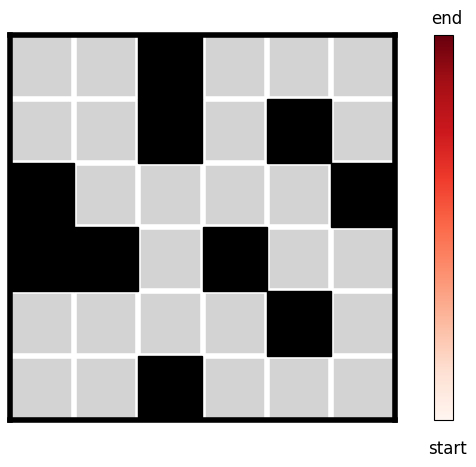

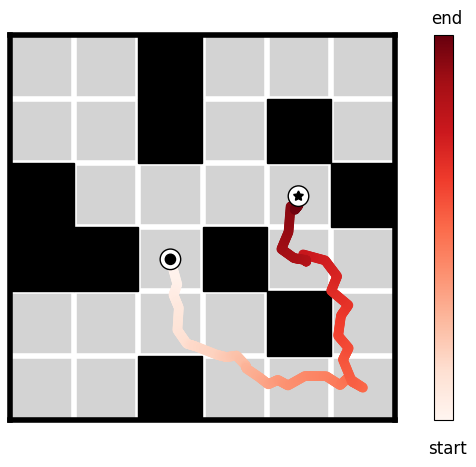

In [57]:
def constrained_path(start_point: np.ndarray=None, end_point: np.ndarray=None):
    
    fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    if start_point is None:
        start_point=np.array([3, 3])[None,...]
    if end_point is None:
        goal_point=np.array([5, 4])[None,...]

    start_point, goal_point = scaler.transform(start_point), scaler.transform(goal_point)

    center_point = scaler.transform(np.array([6, 1])[None,:])

    def initialize(constrained: bool=False):
        ln=find_length(start_point[0], goal_point[0], device=device)
        ln=40

        idx = np.floor(ln*np.linalg.norm(start_point-center_point)/np.linalg.norm(start_point-goal_point)).astype(int)
        idx=20

        Alpha = torch.stack((torch.linspace(1.0,0.0, 80 + 1, device = device),)*((length//inter)), axis = 1)
        Alpha[:,ln]=0
        Alpha[:,0]=0

        mask = torch.ones((length//inter), device = device)
        mask[ln]=0
        mask[0]=0

        mask = torch.concatenate((mask[:,np.newaxis], mask[:,np.newaxis]), axis = 1)

        sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7, Alpha=Alpha, mask=mask)
        n_bs = 1

        x0s = base.sample(n=n_bs, l=length//inter)
        x0s = x0s.to(device)
        x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
        x_init[:, 0, ln], x_init[:, 0, 0] = torch.tensor(goal_point, device=device), torch.tensor(start_point, device=device)

        if constrained:
            Alpha[:,idx]=0
            mask[idx]=0
            x_init[:,0,idx]=torch.tensor(center_point, device=device)
        return x_init
    
    x_init=initialize(constrained=False)
    
    x_final=sde.solve(x_init).squeeze(2) #Remove the channel axis
    x1s=x_final[-1].cpu().detach().numpy() #Keep the last time step
    x1s=x1s[:,:ln+1]
    n=600//ln
    x1s=interpolate(x1s, length=ln*n, inter=n)
    plot_maze(obs=x1s, scaler=scaler, save=False, ax=ax[0])
    
    x_init=initialize(constrained=True)
    x_final=sde.solve(x_init).squeeze(2) #Remove the channel axis
    x1s=x_final[-1].cpu().detach().numpy() #Keep the last time step
    x1s=x1s[:,:ln+1]
    n=600//ln
    x1s=interpolate(x1s, length=ln*n, inter=n)
    plot_maze(obs=x1s, scaler=scaler, save=False, ax=ax[1])

constrained_path()